# クラス分類器の不確実性推定

分類予測の不確実性を調べる関数はdecision_functionとpredict_proba。

In [1]:
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_circles
X, y = make_circles(noise=0.25, factor=0.5, random_state=1)

y_named = np.array(["blue", "red"])[y]

X_train, X_test, y_train_named, y_test_named, y_train, y_test = train_test_split(X, y_named, y, random_state=0)

gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train_named)

/Users/user/.pyenv/versions/miniconda3-3.10.1/envs/py35/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False)

# 決定関数（Decision Function）

モデルが推定値を信じてる度合いを出力できる。

In [2]:
print("X_test.shape: {}".format(X_test.shape))
print("Decision function shape: {}".format(gbrt.decision_function(X_test).shape))

X_test.shape: (25, 2)
Decision function shape: (25,)


In [3]:
#数値を見れば予測クラスもわかる
print("Decision function:\n{}".format(gbrt.decision_function(X_test)[:6]))

Decision function:
[ 4.13592629 -1.7016989  -3.95106099 -3.62599351  4.28986668  3.66166106]


In [4]:
print("Thresholded decision function:\n{}".format(gbrt.decision_function(X_test) > 0))
print("Predictions:\n{}".format(gbrt.predict(X_test)))

Thresholded decision function:
[ True False False False  True  True False  True  True  True False  True
  True False  True False False False  True  True  True  True  True False
 False]
Predictions:
['red' 'blue' 'blue' 'blue' 'red' 'red' 'blue' 'red' 'red' 'red' 'blue'
 'red' 'red' 'blue' 'red' 'blue' 'blue' 'blue' 'red' 'red' 'red' 'red'
 'red' 'blue' 'blue']


In [5]:
greater_zero = (gbrt.decision_function(X_test) > 0).astype(int)
pred = gbrt.classes_[greater_zero]

print("pred is equal to predictions: {}".format(np.all(pred == gbrt.predict(X_test))))

pred is equal to predictions: True


In [6]:
decision_function = gbrt.decision_function(X_test)
print("Decision function minimum: {:.2f} maximum: {:.2f}".format(np.min(decision_function), np.max(decision_function)))

Decision function minimum: -7.69 maximum: 4.29


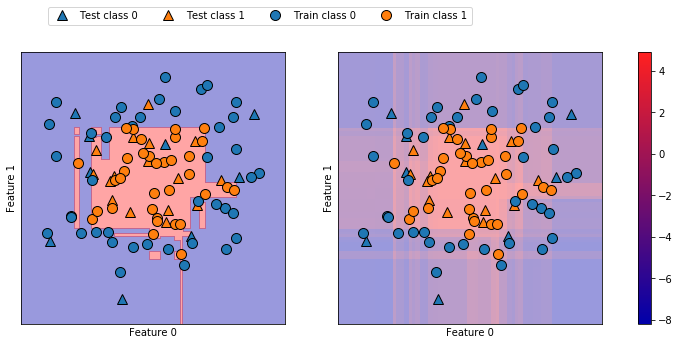

In [17]:
import mglearn
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
mglearn.tools.plot_2d_separator(gbrt, X, ax=axes[0], alpha=.4, fill=True, cm=mglearn.cm2)
scores_image = mglearn.tools.plot_2d_scores(gbrt, X, ax=axes[1], alpha=.4, cm=mglearn.ReBl)

for ax in axes:
    mglearn.discrete_scatter(X_test[:, 0], X_test[:, 1], y_test, markers='^', ax=ax)
    mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train, markers='o', ax=ax)
    ax.set_xlabel("Feature 0")
    ax.set_ylabel("Feature 1")

cbar = plt.colorbar(scores_image, ax=axes.tolist())
cbar.set_alpha(1)
cbar.draw_all()
axes[0].legend(["Test class 0", "Test class 1", "Train class 0", "Train class 1"], ncol=4, loc=(.1, 1.1))
plt.show()

予測結果だけでなく確信度も表現されている。しかし決定境界がわかりにくい。

# 確率の予測

In [18]:
print("Shape of probabilities: {}".format(gbrt.predict_proba(X_test).shape))

Shape of probabilities: (25, 2)


In [19]:
print("Predicted probabilities:\n{}".format(gbrt.predict_proba(X_test[:6])))

Predicted probabilities:
[[ 0.01573626  0.98426374]
 [ 0.84575649  0.15424351]
 [ 0.98112869  0.01887131]
 [ 0.97406775  0.02593225]
 [ 0.01352142  0.98647858]
 [ 0.02504637  0.97495363]]


二つのクラスの確率の和が１。上の例は比較的確信度が高い。複雑さの低いモデルの予測は確信度が低い。    
あるモデルの報告する確信度と実際の正解率が一致している場合は  calibratedされてるという。例えば70%の確信度のデータポイントに対して70%の正答ができる場合はそのモデルはcalibratedされている。

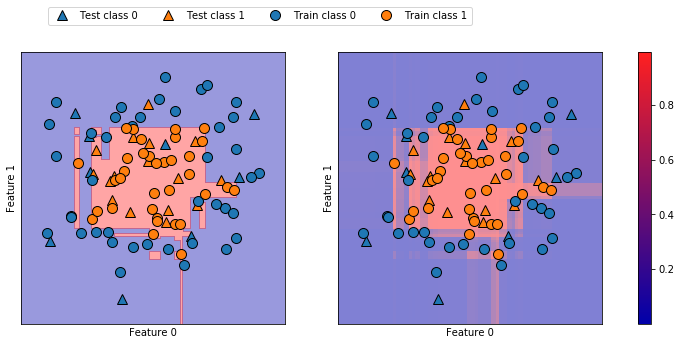

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
    
mglearn.tools.plot_2d_separator(
    gbrt, X, ax=axes[0], alpha=.4, fill=True, cm=mglearn.cm2)
scores_image = mglearn.tools.plot_2d_scores(
    gbrt, X, ax=axes[1], alpha=.5, cm=mglearn.ReBl, function='predict_proba')

for ax in axes:
    mglearn.discrete_scatter(X_test[:, 0], X_test[:, 1], y_test, markers='^', ax=ax)
    mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train, markers='o', ax=ax)
    ax.set_xlabel("Feature 0")
    ax.set_ylabel("Feature 1")

cbar = plt.colorbar(scores_image, ax=axes.tolist())
cbar.set_alpha(1)
cbar.draw_all()
axes[0].legend(["Test class 0", "Test class 1", "Train class 0", "Train class 1"], ncol=4, loc=(.1, 1.1))
plt.show()

この図の境界はしっかりしており、確信度が低い領域もわかりやすい。

# 多クラス分類の不確実性

In [23]:
from sklearn.datasets import load_iris

iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=42)

gbrt = GradientBoostingClassifier(learning_rate=0.01, random_state=0)
gbrt.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=0,
              subsample=1.0, verbose=0, warm_start=False)

In [24]:
print("Decision function shape: {}".format(gbrt.decision_function(X_test).shape))
print("Decision function:\n{}".format(gbrt.decision_function(X_test)[:6, :]))

Decision function shape: (38, 3)
Decision function:
[[-0.52931069  1.46560359 -0.50448467]
 [ 1.51154215 -0.49561142 -0.50310736]
 [-0.52379401 -0.4676268   1.51953786]
 [-0.52931069  1.46560359 -0.50448467]
 [-0.53107259  1.28190451  0.21510024]
 [ 1.51154215 -0.49561142 -0.50310736]]


In [25]:
print("Argmax of decision function:\n{}".format(np.argmax(gbrt.decision_function(X_test), axis=1)))
print("Predictions:\n{}".format(gbrt.predict(X_test)))

Argmax of decision function:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]
Predictions:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]


In [26]:
print("Predicted probabilities:\n{}".format(gbrt.predict_proba(X_test)[:6]))
print("Sums: {}".format(gbrt.predict_proba(X_test)[:6].sum(axis=1)))

Predicted probabilities:
[[ 0.10664722  0.7840248   0.10932798]
 [ 0.78880668  0.10599243  0.10520089]
 [ 0.10231173  0.10822274  0.78946553]
 [ 0.10664722  0.7840248   0.10932798]
 [ 0.10825347  0.66344934  0.22829719]
 [ 0.78880668  0.10599243  0.10520089]]
Sums: [ 1.  1.  1.  1.  1.  1.]


In [27]:
print("Argmax of predicted probabilities:\n{}".format(np.argmax(gbrt.predict_proba(X_test), axis=1)))
print("Predictions:\n{}".format(gbrt.predict(X_test)))

Argmax of predicted probabilities:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]
Predictions:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]


In [29]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

named_target = iris.target_names[y_train]
logreg.fit(X_train, named_target)
print("unique classes in training data: {}".format(logreg.classes_))
print("predictions: {}".format(logreg.predict(X_test)[:10]))
argmax_dec_func = np.argmax(logreg.decision_function(X_test), axis=1)
print("argmax of decision function: {}".format(argmax_dec_func[:10]))
print("argmax combined with classes_: {}".format( logreg.classes_[argmax_dec_func][:10]))

unique classes in training data: ['setosa' 'versicolor' 'virginica']
predictions: ['versicolor' 'setosa' 'virginica' 'versicolor' 'versicolor' 'setosa'
 'versicolor' 'virginica' 'versicolor' 'versicolor']
argmax of decision function: [1 0 2 1 1 0 1 2 1 1]
argmax combined with classes_: ['versicolor' 'setosa' 'virginica' 'versicolor' 'versicolor' 'setosa'
 'versicolor' 'virginica' 'versicolor' 'versicolor']
